In [1]:
import os
import torch

from PIL import Image
from torchvision import models
from torchvision import transforms


import numpy as np
import matplotlib.pyplot as plt

In [2]:
target_classes = {
    248 : ["n02109961", "Eskimo_dog"],
    249 : ["n02110063", "malamute"],
    250 : ["n02110185", "Siberian_husky"],

    282 : ["n02123159", "tiger_cat"],
    284 : ["n02123597", "Siamese_cat"],
    286 : ["n02125311", "cougar"]}

data_dir = '/home/jaeseong_lee/data/ImageNet/train/'

imgs_path = []
for target_class in target_classes:
    target_class_dir = os.path.join(data_dir, str(target_class))
    for file in sorted(os.listdir(target_class_dir)):
        img_path = os.path.join(target_class_dir, file)
        imgs_path.append(img_path)
        break

In [3]:
weights = models.VGG19_BN_Weights.IMAGENET1K_V1
net = models.vgg19_bn(weights=weights)

for param in net.parameters():
    param.requires_grad = False

net.cuda().eval()

print(weights.transforms())

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [4]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def preprocess(img):
    resize = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(256)])
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ])
    pil_img = resize(img)
    img_tensor = transform(pil_img)
    return pil_img, img_tensor

In [5]:
imgs, saliency_maps = [], []

for target_class, img_path in zip(target_classes, imgs_path):
    pil_img = Image.open(img_path)
    pil_img, img_tensor = preprocess(pil_img)
    imgs.append(pil_img)

    img_tensor = img_tensor.unsqueeze(0)  # (1, 3, 256, 256)
    img_tensor = torch.autograd.Variable(img_tensor, requires_grad=True)

    logits = net(img_tensor.cuda())    # (1, 1000)
    logits = logits.squeeze(0)         # (1000)
    score = logits[target_class]
    
    loss = -score
    loss.backward()

    img_grad = img_tensor.grad.data    # (1, 3, 256, 256)
    img_grad = img_grad.squeeze(0)     # (3, 256, 256)
    abs_img_grad = img_grad.abs()      # (3, 256, 256)
    saliency_map, _ = img_grad.max(0)  # (256, 256)
    saliency_map = saliency_map.numpy()
    saliency_maps.append(saliency_map)

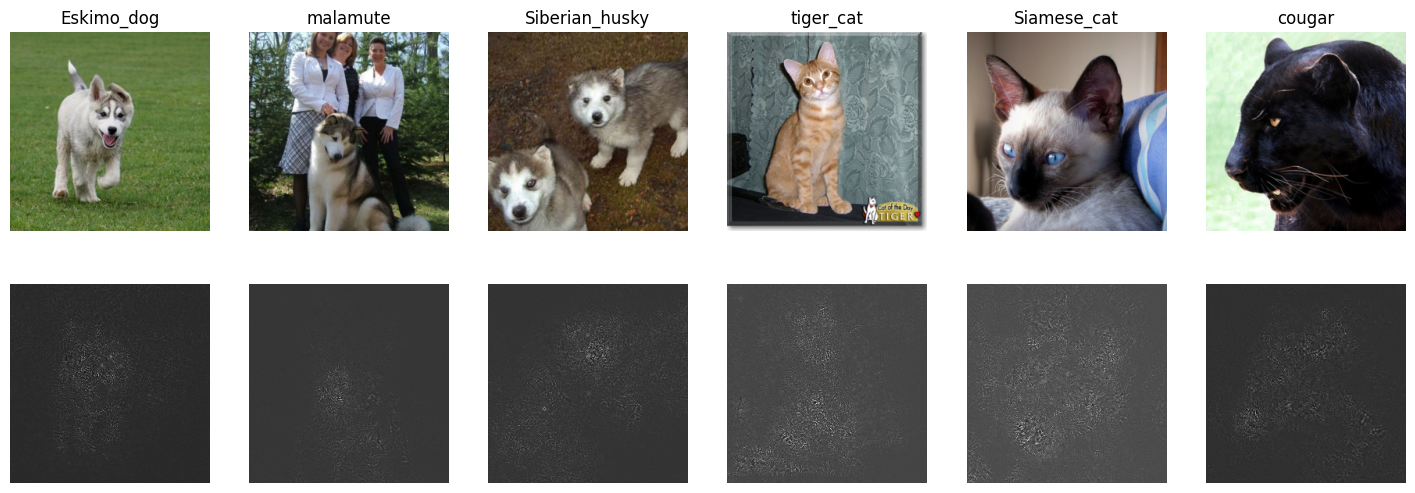

In [6]:
row, col = 2, len(target_classes)

fig, axs = plt.subplots(row, col, figsize=(3 * col, 3 * row))

for i, target_class in enumerate(target_classes):
    axs[0][i].imshow(imgs[i])
    axs[1][i].imshow(saliency_maps[i], cmap=plt.cm.gray)

    axs[0][i].axis('off')
    axs[1][i].axis('off')

    axs[0][i].set_title(target_classes[target_class][1])

plt.show()